In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import sklearn.metrics
import numpy as np

## Comparing classifications

### Getting conflicts

In [2]:
JT = pd.read_csv('JT-classification.csv', index_col='Stimulus_Number')
SK = pd.read_csv('SK-classification.csv', index_col='Stimulus_Number')

conflicts = JT.eq(SK)[~JT.eq(SK).all(axis=1)]
conflicts = conflicts.rename(columns=lambda x: x.split('_')[0] + ' Agreement')

conflicts

,Social Agreement,Face Agreement,Person Agreement
Stimulus_Number,,,
285993,True,True,False
286001,True,False,True
1159325,True,False,True
1159870,True,False,True
1160049,False,True,True
1160227,True,True,False
1592094,True,False,False
1592137,True,False,True
1592568,True,True,False


In [3]:
len(conflicts)

10

In [4]:
conflicts.to_csv('JT-SK-conflicts.csv')

### Inter-rater reliability

In [5]:
cats = JT.columns
merged = pd.merge(JT, SK, on='Stimulus_Number', how='outer', suffixes=['_JT', '_SK'])

for cat in cats:
    kappa = sklearn.metrics.cohen_kappa_score(merged[f'{cat}_JT'], merged[f'{cat}_SK'])
    print(f'{cat} kappa = {kappa:.2f}')

Social_NonSocial kappa = 0.97
Face_NoFace kappa = 0.83
Person_NoPerson kappa = 0.81


## Behavioral data

In [6]:
# Image classification data, after SK and JT agreed on conflicts
image_categories = pd.read_csv('consensus-classification.csv')

In [7]:
# Data from the experiment.
behavioral_data = pd.read_csv('behavioral_data.csv')

In [8]:
# Function to extract image ID from stimulus label in behavioral data 
def extract_image_id(stimulus):
    match = re.search(r'fps_60/(\d+)\.bmp', stimulus)
    if match:
        return int(match.group(1))
    return None

# Apply the function to create a new column with the extracted image IDs (makes the moviestim values match stimuli values in image_categories)
behavioral_data['Stimulus_Number'] = behavioral_data['moviestim'].apply(extract_image_id)

In [9]:
# Add stimulus categories for face, person, and social onto dataframe.
# Will match by stimulus number, so if the image_categories entry for 1234 
# has NonSocial, NoFace, Person, then all behavioral_data rows with stimulus
# 1234 will add those 3 values in their own columns.

behavioral_data = behavioral_data.merge(image_categories, on='Stimulus_Number')

In [10]:
# add column Judgment: whether the subject *thinks* the stimulus is real or fake (regardless of actual value)
def judgment_type(response_type):
    if response_type in ['Hit', 'False Alarm']:
        return 'Judged Real'
    elif response_type in ['Miss', 'Correct Reject']:
        return 'Judged Fake'
    
    return pd.NA


behavioral_data['Judgment'] = behavioral_data.response_type.map(judgment_type)

In [11]:
behavioral_data.participant.value_counts()

participant
subject_4c     120
sub_1          120
subject_9      120
subject_22     120
subject_6      120
subject_19     120
subject_2      120
subject_8      120
subject_14     120
subject_16c    120
subject_12     120
subject_11     120
Subject_7      120
subject_5      120
subject_13     120
subject_20b    120
subject_10     120
subject_15     120
subject_18     120
subject_3      120
subject_23     120
subject_21      60
Name: count, dtype: int64

## Judgments by category

### Crosstab data

In [12]:
# Get contingency table breakdown of each judgment for each classing
face_judgments   = pd.crosstab(behavioral_data.Judgment, behavioral_data.Face_NoFace)
person_judgments = pd.crosstab(behavioral_data.Judgment, behavioral_data.Person_NoPerson)
social_judgments = pd.crosstab(behavioral_data.Judgment, behavioral_data.Social_NonSocial)


# Reorders the crosstab rows so that Judged Real comes first, then Judged Fake.
# Does NOT just rename the indices by this list—that would swap the real and fake
# data!
face_judgments   = face_judgments.reindex(['Judged Real', 'Judged Fake'], columns=['Face', 'No Face'])
person_judgments = person_judgments.reindex(['Judged Real', 'Judged Fake'], columns=['Person', 'No Person'])
social_judgments = social_judgments.reindex(['Judged Real', 'Judged Fake'], columns=['Social', 'Non-Social'])

### Statistical test

In [13]:
print(f'N = {face_judgments.values.sum()}')
face_judgments

N = 2514


Face_NoFace,Face,No Face
Judgment,,
Judged Real,940,663
Judged Fake,486,425


In [14]:
print(f'N = {person_judgments.values.sum()}')
person_judgments

N = 2514


Person_NoPerson,Person,No Person
Judgment,,
Judged Real,1073,530
Judged Fake,598,313


In [15]:
print(f'N = {social_judgments.values.sum()}')
social_judgments

N = 2514


Social_NonSocial,Social,Non-Social
Judgment,,
Judged Real,976,627
Judged Fake,528,383


To determine if class status (eg. Face/No Face) affects judgment, we can run a chi-squared test. The null hypothesis is that class status and judgment are statistically independent. So if, say, 70% of all stimuli include faces, and 55% of all stimuli are judged real, the *expected* frequency of Face & Judged Real = `0.7 * 0.55 * N`, where `N` is the total number of *all* judgments made. We test to see how far the data departs from this expectation of independence.

In [17]:
categories = ['Social_NonSocial', 'Face_NoFace', 'Person_NoPerson']
judgment_data = [social_judgments, face_judgments, person_judgments]
cat_test_dict = {}

for cat, cross in zip(categories, judgment_data):
    chi2, p, dof, expected_distro = scipy.stats.chi2_contingency(cross)

    exposed_cases = cross.iloc[0, 0]
    exposed_total = cross.iloc[:, 0].sum()

    control_cases = cross.iloc[0, 1]
    control_total = cross.iloc[:, 1].sum()

    risk_ratio = scipy.stats.contingency.relative_risk(exposed_cases, exposed_total, 
                                                       control_cases, control_total).relative_risk

    # Check that there are at least 5 observations for each cell in the
    # expected contingency table; otherwise the chi-squared test won't
    # be a strong approximation.
    # See https://methods.sagepub.com/book/nonparametric-statistics-for-health-care-research-2e/i462.xml
    assert np.all(expected_distro >= 5)

    cat_test_dict[cat] = {'chi2': chi2, 'risk_ratio': risk_ratio, 'dof': dof, 'p': p, 'p < 0.05': p < 0.05}

category_test_results = pd.DataFrame(cat_test_dict).T
category_test_results

,chi2,risk_ratio,dof,p,p < 0.05
Social_NonSocial,1.951352,1.045336,1,0.162441,False
Face_NoFace,6.413245,1.081742,1,0.011327,True
Person_NoPerson,0.3808,1.021351,1,0.537175,False


### Plots

In [18]:
# Plots a cross-tabulated dataframe.
# Just a nice function to do the resetting, melting, & seaborn-ing for you.
def plot_crosstab(df_crosstab, **plot_options):
    df_reset = df_crosstab.reset_index()
    id_col = df_reset.columns[0]

    df_melt = df_reset.melt(id_vars=id_col, value_name='count')
    cat_col = df_melt.columns[1]

    sns.barplot(x=id_col, y='count', hue=cat_col, data=df_melt, **plot_options)

Text(0, 0.5, 'Number of judgments')

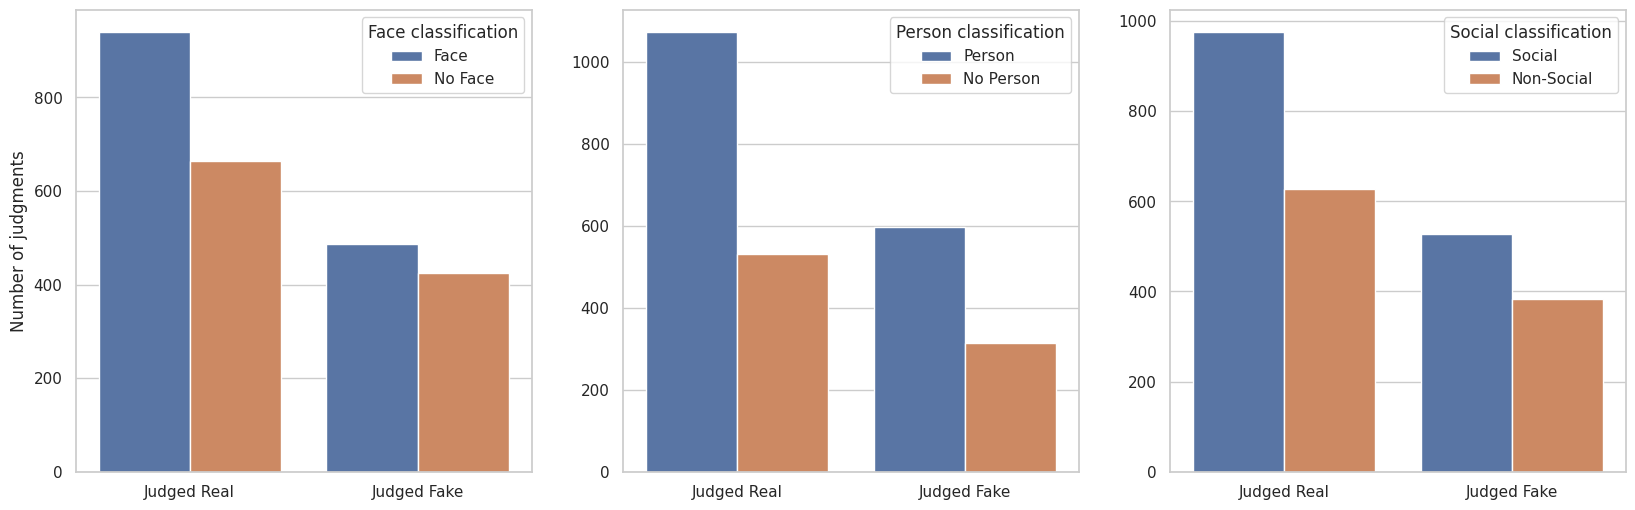

In [65]:
# Plot each side-by-side!
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plot_crosstab(face_judgments, ax=axes[0])
axes[0].legend(title='Face classification')

plot_crosstab(person_judgments, ax=axes[1],)
axes[1].legend(title='Person classification')

plot_crosstab(social_judgments, ax=axes[2])
axes[2].legend(title='Social classification')


for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

axes[0].set_ylabel('Number of judgments')

## Judgement-category interactions by subject

### Statistical test

**For significance testing**, to see if each category affects the judgment of *individual* subjects, we can run a chi-squared test for each individual's contingency table, as long as the test conditions are met. The chi-squared test is a two-tailed test, so the statistic itself doesn't report whether a stimulus category is, say, more likely to be judged fake. 

**For visualization & interpretation**, we'd like a number that says "stimuli with faces are X times more likely to be judged real than stimuli without faces." In epidemiology, this is known as the *risk ratio*, and it is calculated by: $$RR = \frac{P(\text{Judged Real}\, |\,\text{Face})}{P(\text{Judged Real}\,|\,\text{Non-Face})} = \frac{\text{Face \& Judged Real}}{\text{All Face}}\div \frac{\text{Non-Face \& Judged Real}}{\text{All Non-Face}}$$

So if subject 7 has a risk ratio of 2 for faces, it means subject 7 was twice as likely to rate a face stimulus as real, compared to a non-face stimulus. If subject 5 has a risk ratio of 1 for faces, it means they are equally likely to judge face and non-face stimuli as real. Risk ratios can range from (0, $\infty$).


Reference links: [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.relative_risk.html), [Ranganathan et al. 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4640017/), [George et al. 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7515812/)

In [19]:
rows = []
for sub in behavioral_data.participant.unique():
    for cat in categories:
        sub_data = behavioral_data[behavioral_data.participant.eq(sub)]
        sub_cross = pd.crosstab(sub_data.Judgment, sub_data[cat])
        
        # Significance test        
        chi2_results = scipy.stats.chi2_contingency(sub_cross)
        p_value = chi2_results.pvalue
        
        # Again, chi2 is not a good test unless expected frequency per category
        # is large enough.
        assert np.all(chi2_results.expected_freq >= 5)

        # Risk ratio
        exposure = cat.split('_')[0] # will be 'Social', 'Face', or 'Person'

        exposed_judged_real = sub_cross.loc['Judged Real', exposure]
        exposed_total = sub_cross.loc[:, exposure].sum()

        control_judged_real = sub_cross.loc['Judged Real', sub_cross.columns != exposure].iloc[0]
        control_total = sub_cross.loc[:, sub_cross.columns != exposure].sum().iloc[0]

        risk_ratio = scipy.stats.contingency.relative_risk(exposed_cases=exposed_judged_real,
                                                           exposed_total=exposed_total,
                                                           control_cases=control_judged_real,
                                                           control_total=control_total).relative_risk



        rows.append({'subject': sub,
                     'category': cat,
                     'risk_ratio': risk_ratio,
                     'chi2_pvalue': p_value,
                     'chi2_significant': p_value < 0.05})

subject_df = pd.DataFrame(rows)

subject_df

,subject,category,risk_ratio,chi2_pvalue,chi2_significant
0,subject_4c,Social_NonSocial,1.282609,0.035658,True
1,subject_4c,Face_NoFace,1.262207,0.042949,True
2,subject_4c,Person_NoPerson,1.304604,0.037976,True
3,sub_1,Social_NonSocial,1.098701,0.763097,False
4,sub_1,Face_NoFace,1.057214,0.914771,False
...,...,...,...,...,...
61,subject_18,Face_NoFace,1.102076,0.558501,False
62,subject_18,Person_NoPerson,0.931034,0.726757,False
63,subject_23,Social_NonSocial,1.185722,0.328555,False
64,subject_23,Face_NoFace,1.289011,0.116337,False


Text(0.5, 19.049999999999997, 'probability ratio')

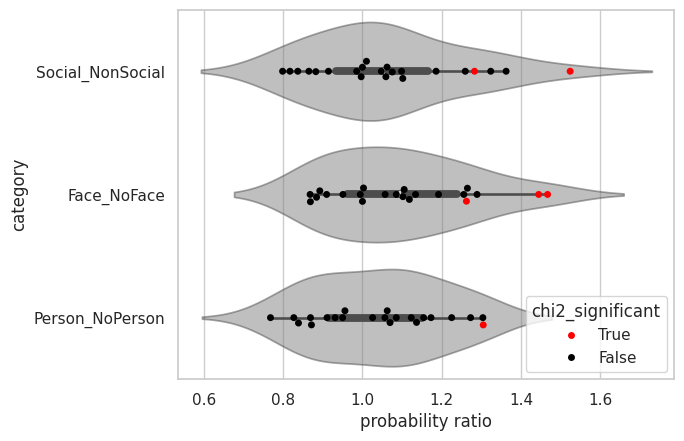

In [18]:
ax = sns.violinplot(x='risk_ratio', 
                    y='category', 
                    data=subject_df, 
                    color='grey', 
                    alpha=0.5)

sns.swarmplot(x='risk_ratio', 
              y='category', 
              data=subject_df,
              hue='chi2_significant', 
              hue_order=[True, False], 
              palette=['red', 'black'],
              ax=ax)

ax.set_xlabel('probability ratio')

## Response types by category

### Crosstab data


In [63]:
# Get cross-tabulated data, this time for all responses
face_responses   = pd.crosstab(behavioral_data['response_type'], behavioral_data['Face_NoFace'])
person_responses = pd.crosstab(behavioral_data['response_type'], behavioral_data['Person_NoPerson'])
social_responses = pd.crosstab(behavioral_data['response_type'], behavioral_data['Social_NonSocial'])

### Plots

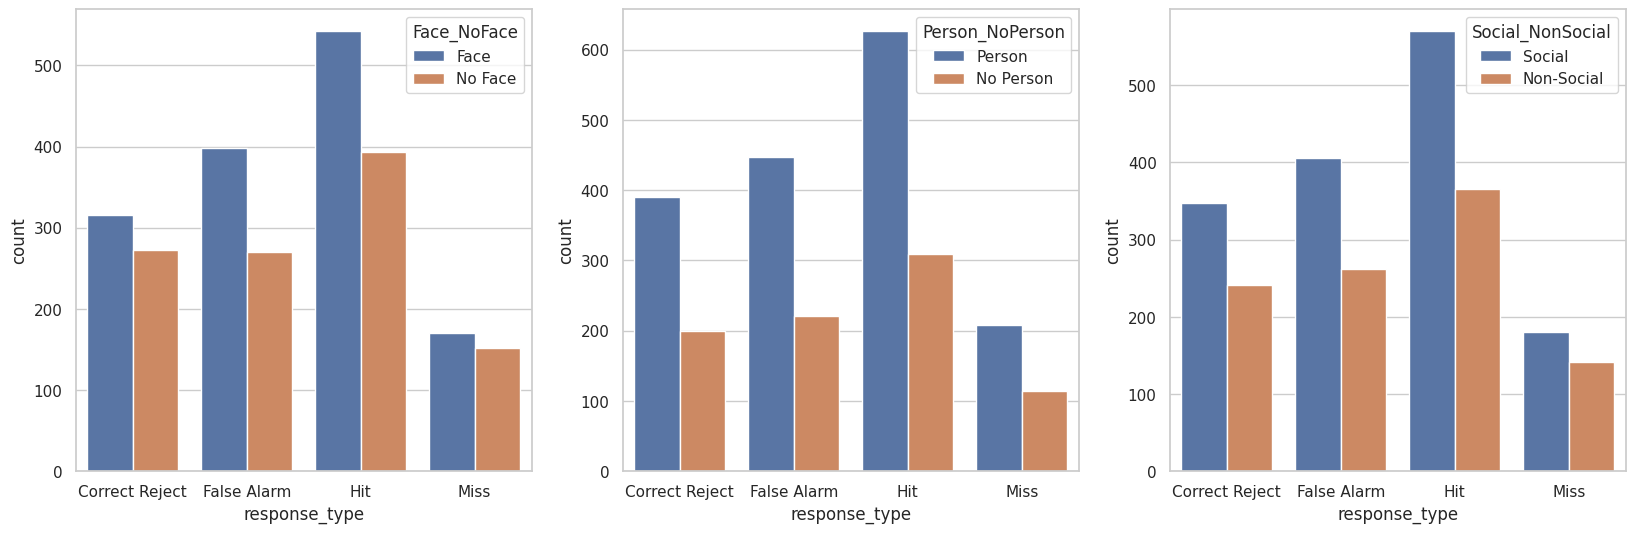

In [64]:
# Get cross-tabulated data, this time for all responses
face_responses   = pd.crosstab(behavioral_data['response_type'], behavioral_data['Face_NoFace'])
person_responses = pd.crosstab(behavioral_data['response_type'], behavioral_data['Person_NoPerson'])
social_responses = pd.crosstab(behavioral_data['response_type'], behavioral_data['Social_NonSocial'])


# Plot each side-by-side! TODO: prettify & include good labels
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plot_crosstab(face_responses,   ax=axes[0], hue_order=['Face', 'No Face'])
plot_crosstab(person_responses, ax=axes[1], hue_order=['Person', 'No Person'])
plot_crosstab(social_responses, ax=axes[2], hue_order=['Social', 'Non-Social'])